## Importing libraries

In [1]:
import os
import tensorflow as tf
import numpy as np

In [147]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Loading Dataset

In [110]:
dataset_dir = os.path.join('Data/')

Batch_size = 8
img_h = 256
img_w = 256
num_classes=20

classes = ['Covid-19', 'No_findings', 'Pneumonia']

### Image Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

### Loading Train and validation dataset

In [8]:
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)


valid_dir = os.path.join(dataset_dir, 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size, 
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)

Found 562 images belonging to 3 classes.
Found 281 images belonging to 3 classes.


### Visualizing dataset

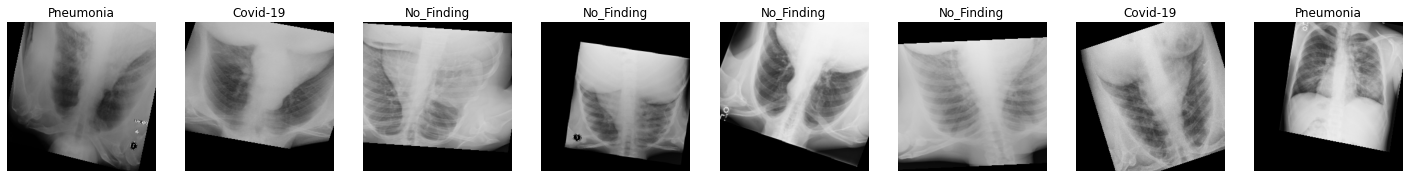

In [9]:
CLASS_NAMES = np.array(['Covid-19', 'No_findings', 'Pneumonia'], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

## Importing Resnet Model to apply Transfer Learning

In [10]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

234553344/234545216 [==============================] - 38s 0us/step


## Building Model

In [12]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=3, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

### Setting Loss function, Optimizer and Compling the model

In [15]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

## Introducing ReduceLROnPlateau

### To reduce learning rate if model stops improving¶

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

70
35


## Training our model

In [21]:
transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                   callbacks=callbacks,)

Epoch 1/20
70/70 [==============================] - 273s 4s/step - loss: 0.9651 - accuracy: 0.4892 - val_loss: 1.9726 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 267s 4s/step - loss: 0.8473 - accuracy: 0.6137 - val_loss: 2.6386 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 313s 4s/step - loss: 0.8746 - accuracy: 0.6047 - val_loss: 1.6350 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 0.7720 - accuracy: 0.6336
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
70/70 [==============================] - 270s 4s/step - loss: 0.7720 - accuracy: 0.6336 - val_loss: 1.4412 - val_accuracy: 0.5643 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 271s 4s/step - loss: 0.7005 - accuracy: 0.6841 - val_loss: 0.6360 - val_accuracy: 0.7071 - lr: 4.0000e-04
Epoch 6/20
70/70 [==============================] - 352s 5s/ste

## Visualizing accuracy and loss

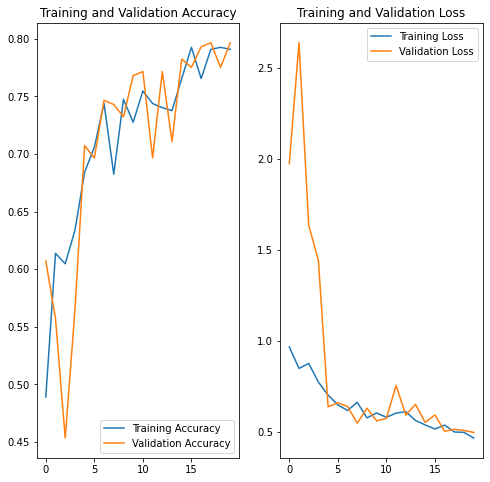

In [144]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving Trained model

In [52]:
from keras.models import model_from_json

In [53]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Testing trained model

In [54]:
test_data_gen = ImageDataGenerator(rescale=1./255)

In [56]:
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=10, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode='categorical',
                                             )

Found 282 images belonging to 3 classes.


In [60]:
STEP_SIZE_TEST = test_gen.n//test_gen.batch_size

In [61]:
model.evaluate(test_gen, steps=STEP_SIZE_TEST,verbose=1)

28/28 [==============================] - 89s 3s/step - loss: 0.6648 - accuracy: 0.7463


[0.6647829413414001, 0.7463235259056091]